In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import warnings
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['figure.figsize']=[16,9]
plt.rcParams['figure.dpi']= 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Corregir el ticker cuando no tengas flojera

In [58]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
import scipy.stats as scs

In [59]:
df = yf.download('GOOG',
                start='2000-01-01',
                end='2019-12-31',
                adjusted=True,
                progress=False)
goog = df.resample('W').last().rename(columns={'Adj Close':'adj_close'}).adj_close
goog.shape

(1044,)

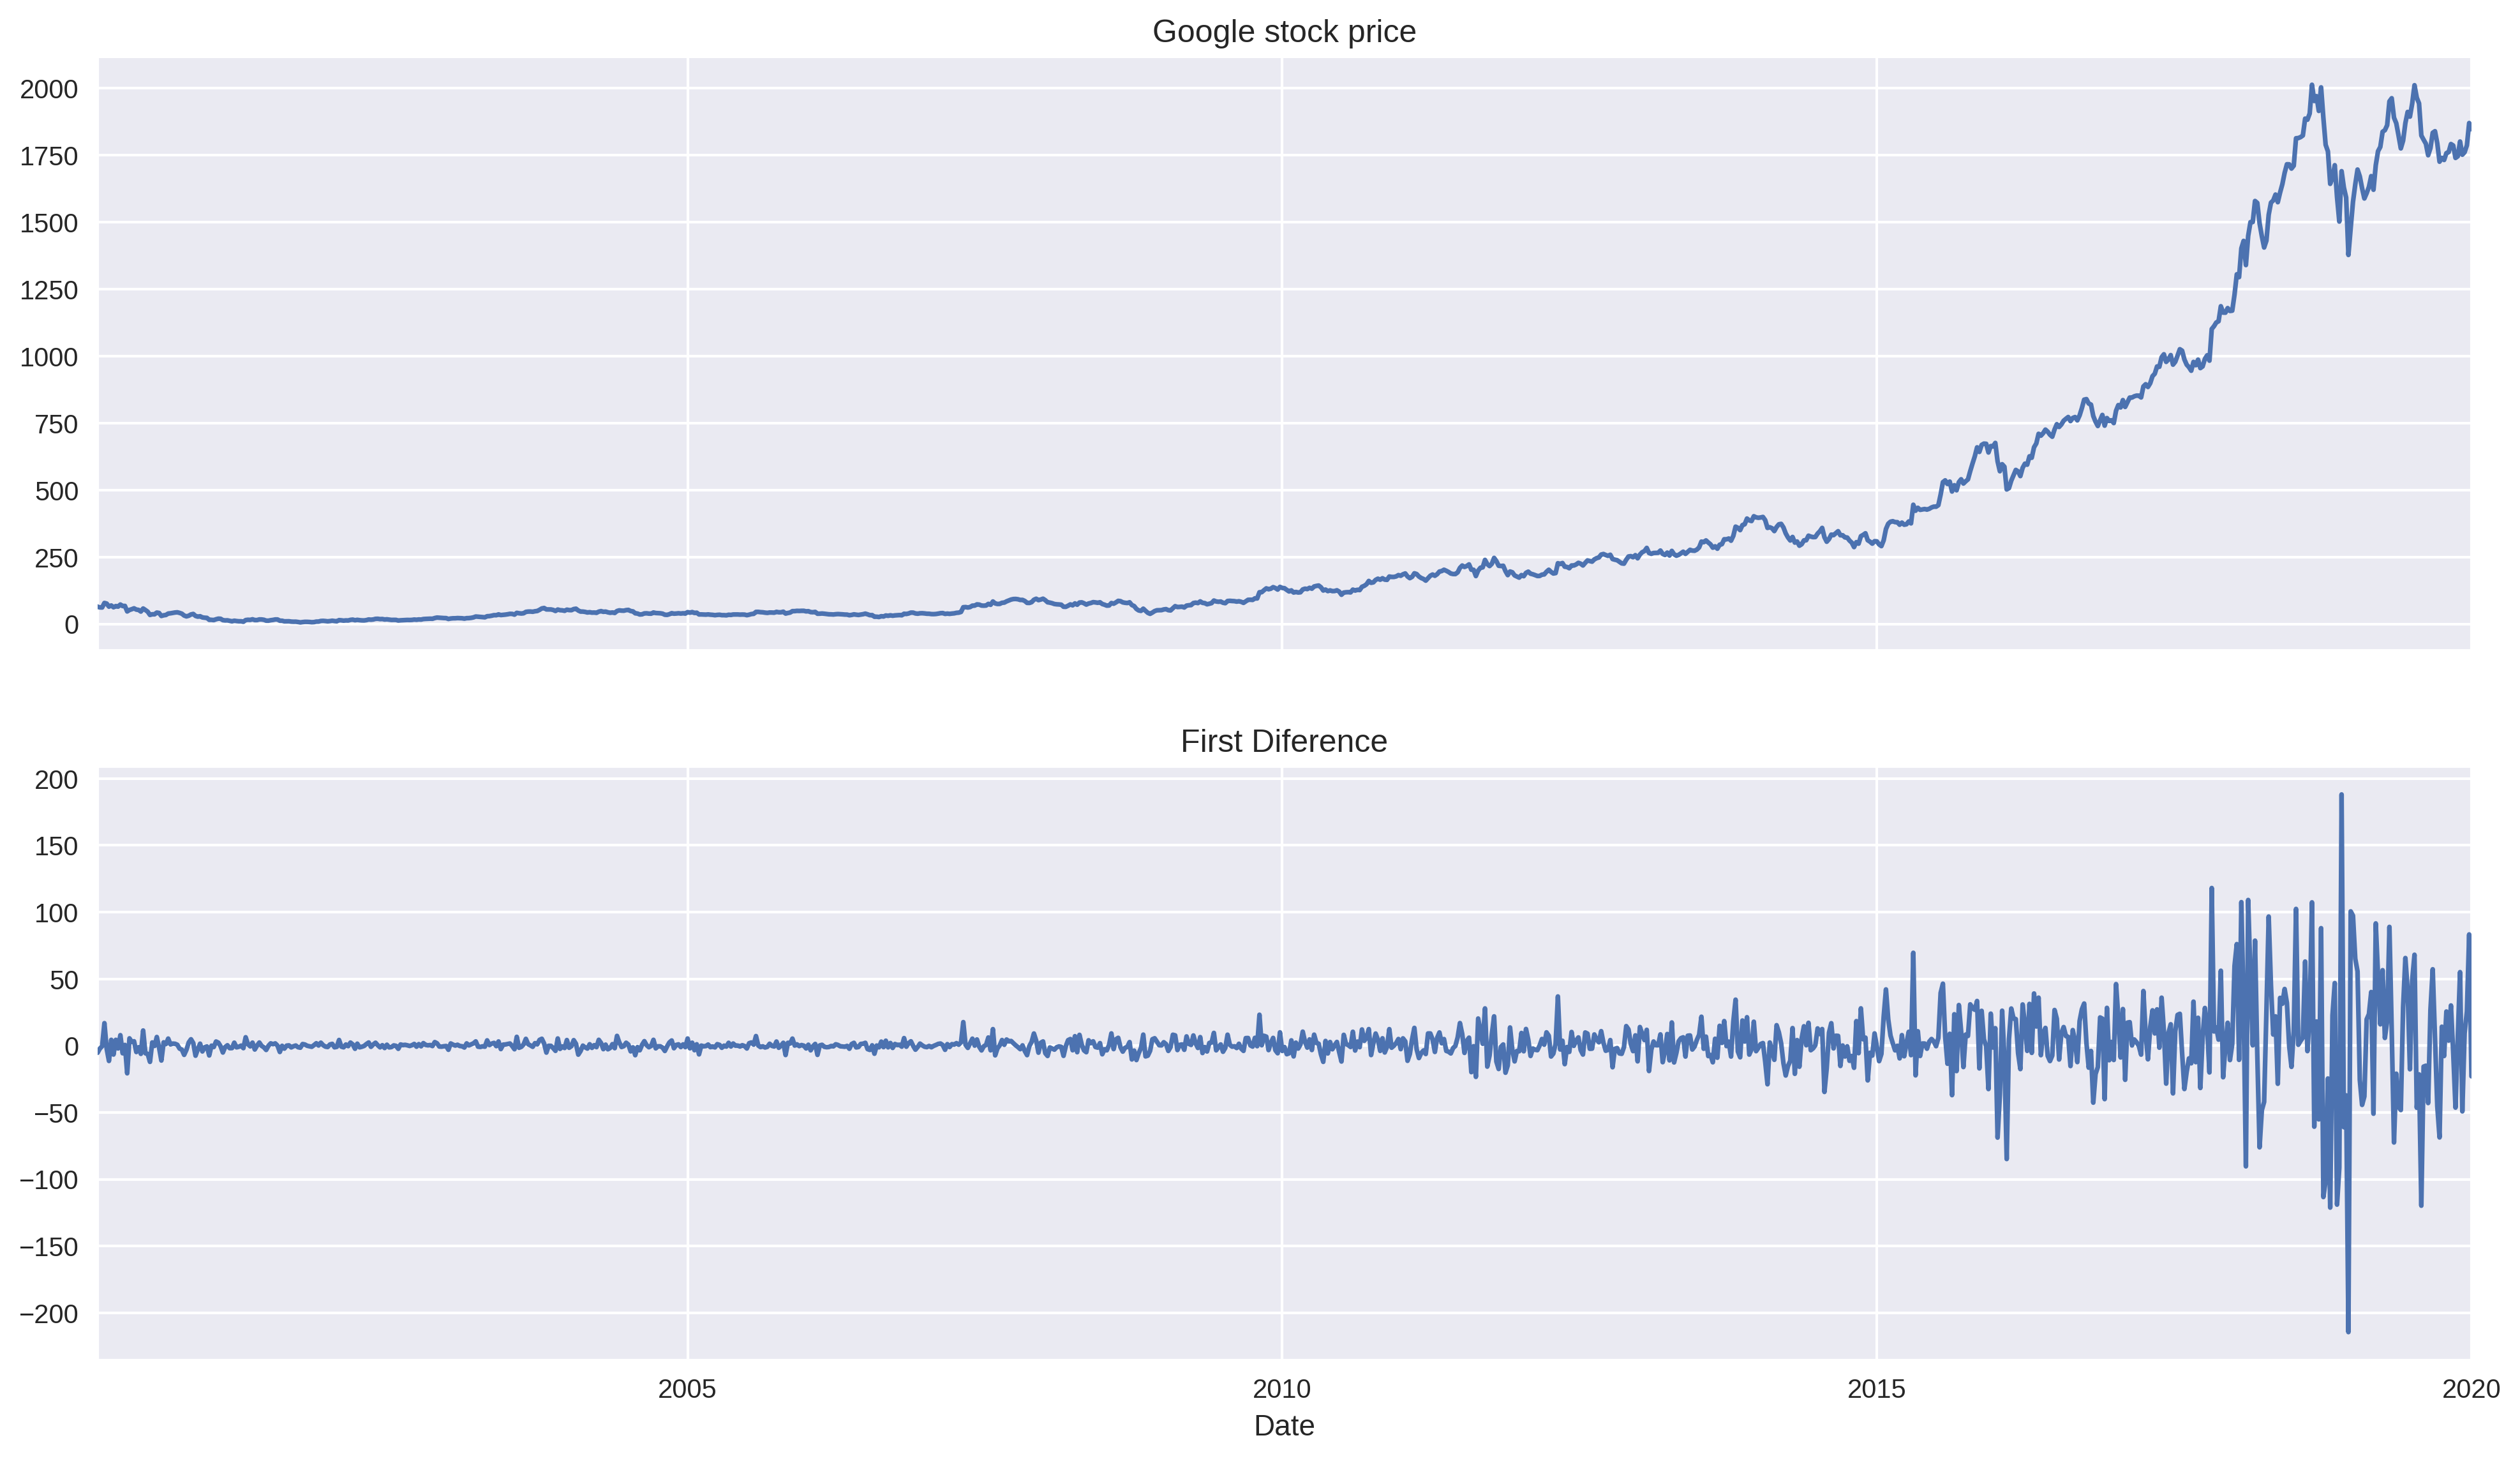

In [60]:
goog_diff = goog.diff().dropna()

fix, ax = plt.subplots(2, sharex=True)
goog.plot(title = 'Google stock price', ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Diference')


(-0.2, 0.2)

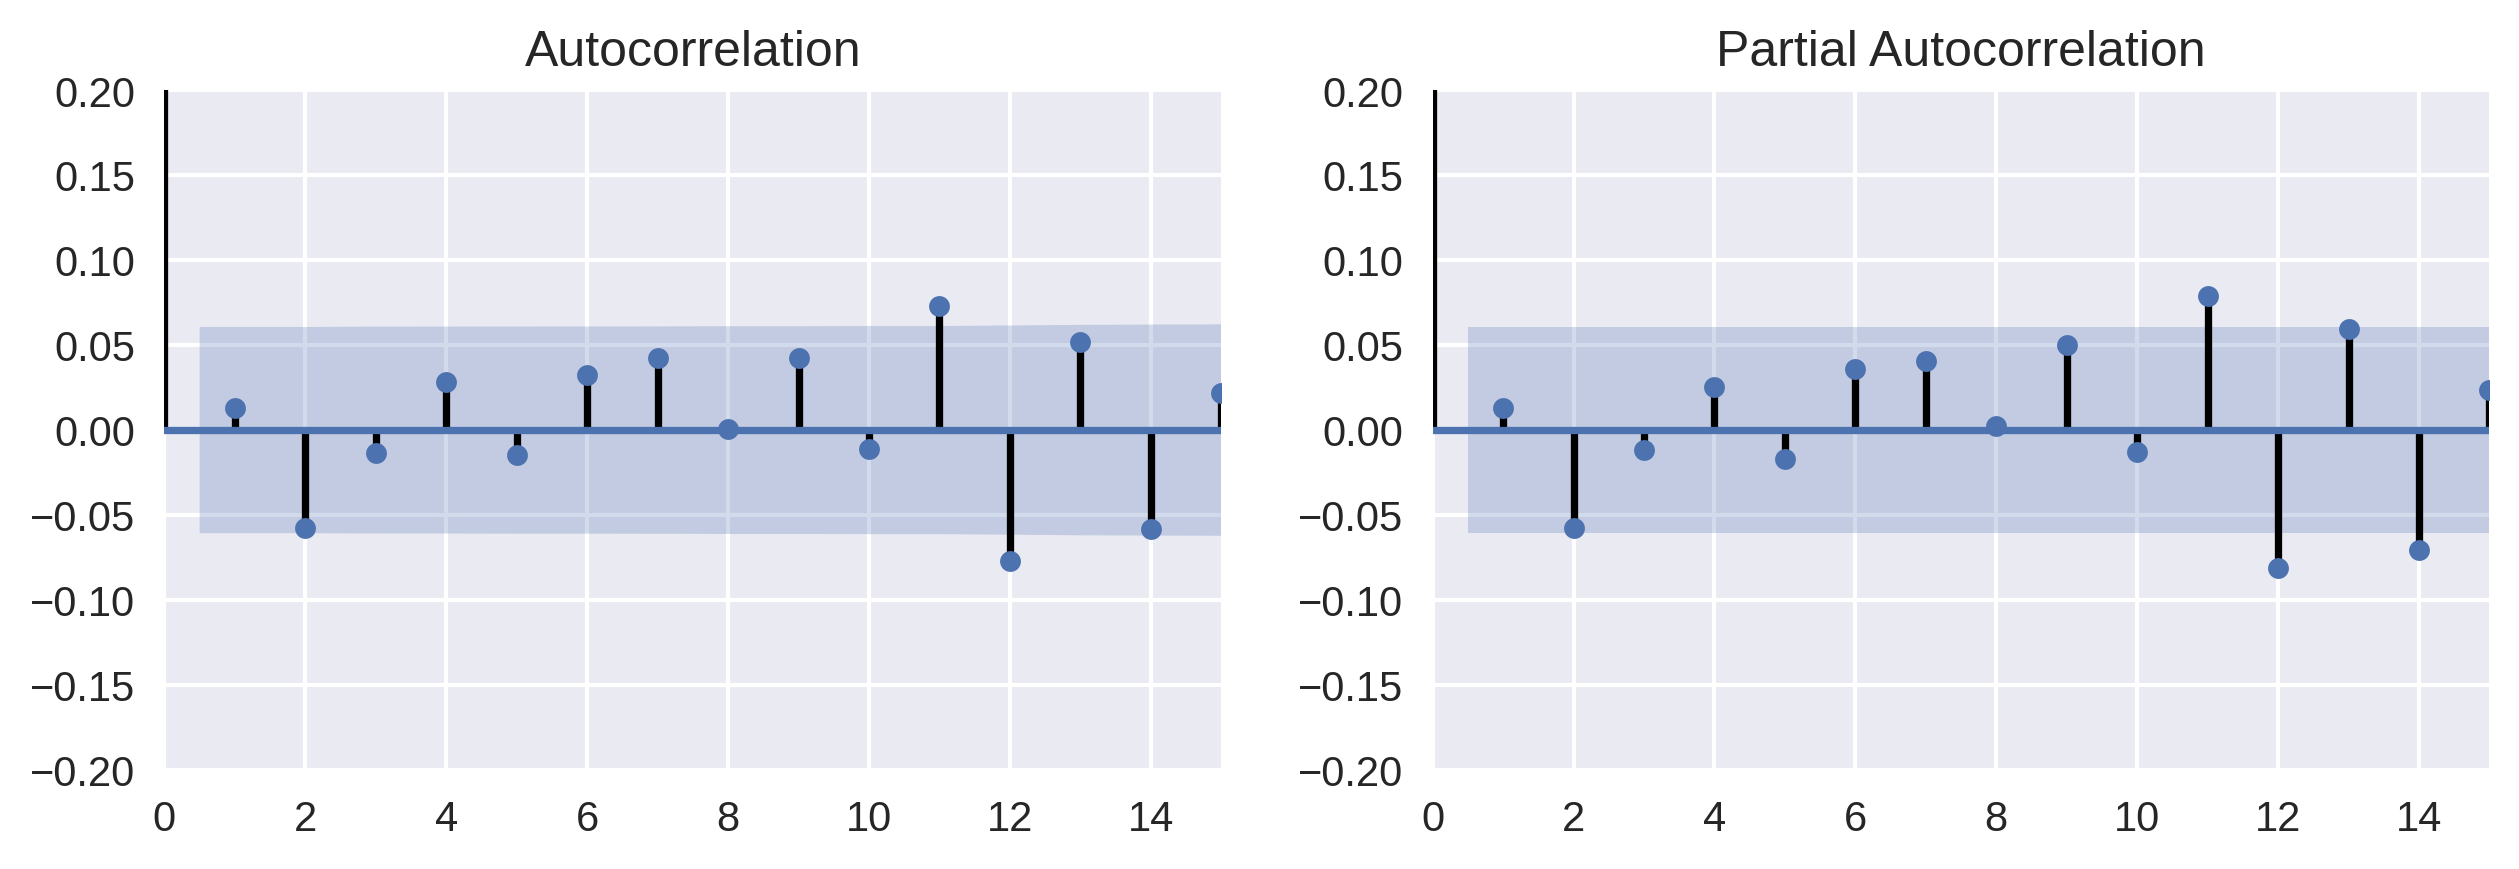

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
# ACF chart
fig = plot_acf(goog_diff, lags=15,ax=ax1)

# PACF chart
fig = plot_pacf(goog_diff, lags=15, ax=ax2)



ax1.set_xlim([0,15])
ax2.set_xlim([0,15])
ax1.set_ylim([-.2,.2])
ax2.set_ylim([-.2,.2])

In [62]:
test_DF = sm.tsa.stattools.adfuller(goog_diff, regression='ct')
# mientas más a la izquierda es mejor
# Si la series ya es estacionaria, no hay más que hacer
print('ADF Statistic: %f' % test_DF[0])
print('p-value: %f' % test_DF[1])
print('Critical Values:')
for key, value in test_DF[4].items():
    print('\t%s: %.3f' % (key,value))
    
if test_DF[0] < test_DF[4]['5%']:
    print('Reject Ho - Time series is Stationary')
else:
    print('Failed to Reject Ho - Times series Non-Stationary')
    
    
# Debemos ver cómo analizar lo de las diferencias, el profesor le agrega diferencias

ADF Statistic: -9.388868
p-value: 0.000000
Critical Values:
	1%: -3.968
	5%: -3.415
	10%: -3.130
Reject Ho - Time series is Stationary


# Model ARIIMA

In [63]:
arima = ARIMA(goog, order=(2,1,1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                 1043
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -4724.057
Method:                       css-mle   S.D. of innovations             22.429
Date:                Sat, 06 Jun 2020   AIC                           9458.114
Time:                        20:34:18   BIC                           9482.864
Sample:                    01-16-2000   HQIC                          9467.502
                         - 01-05-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7007      0.660      2.577      0.010       0.407       2.994
ar.L1.D.adj_close     0.1259      0.390      0.323      0.747      -0.638       0.890
ar.L2.D.adj_close    -0.0601      0.031     -1.927      0.054      -0.121       0.001
ma.L1.D.adj_close    -0.1125      0.390     -0.288      0.773      -0.877       0.652
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0467           -3.9415j            4.0781           -0.2087
AR.2            1.0467           +3.9415j            4.0781            0.2087
MA.1            8.8924           +0.0000j            8.8924            0.0000
-----------------------------------------------------------------------------
"""

## Diagnosing the fit of the model based on its residuals

In [64]:
def arima_diagnostics(resids, n_lags=40):
    #create placeholders subplots
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    
    r = resids
    resids = (r-np.nanmean(r))/np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    #residuals over time
    sns.lineplot(x=np.arange(len(resids)), y = resids, ax=ax1)
    ax1.set_title('Standarized residuals')
    
    #distribution of residuals
    x_lim = (-1.96*2, 1.96*2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g',lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standadized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
    
    
    #Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s',ax=ax3)
    ax3.set_title('Q-Q plot')
    
    #ACF plot 
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF Plot')
    
    return fig

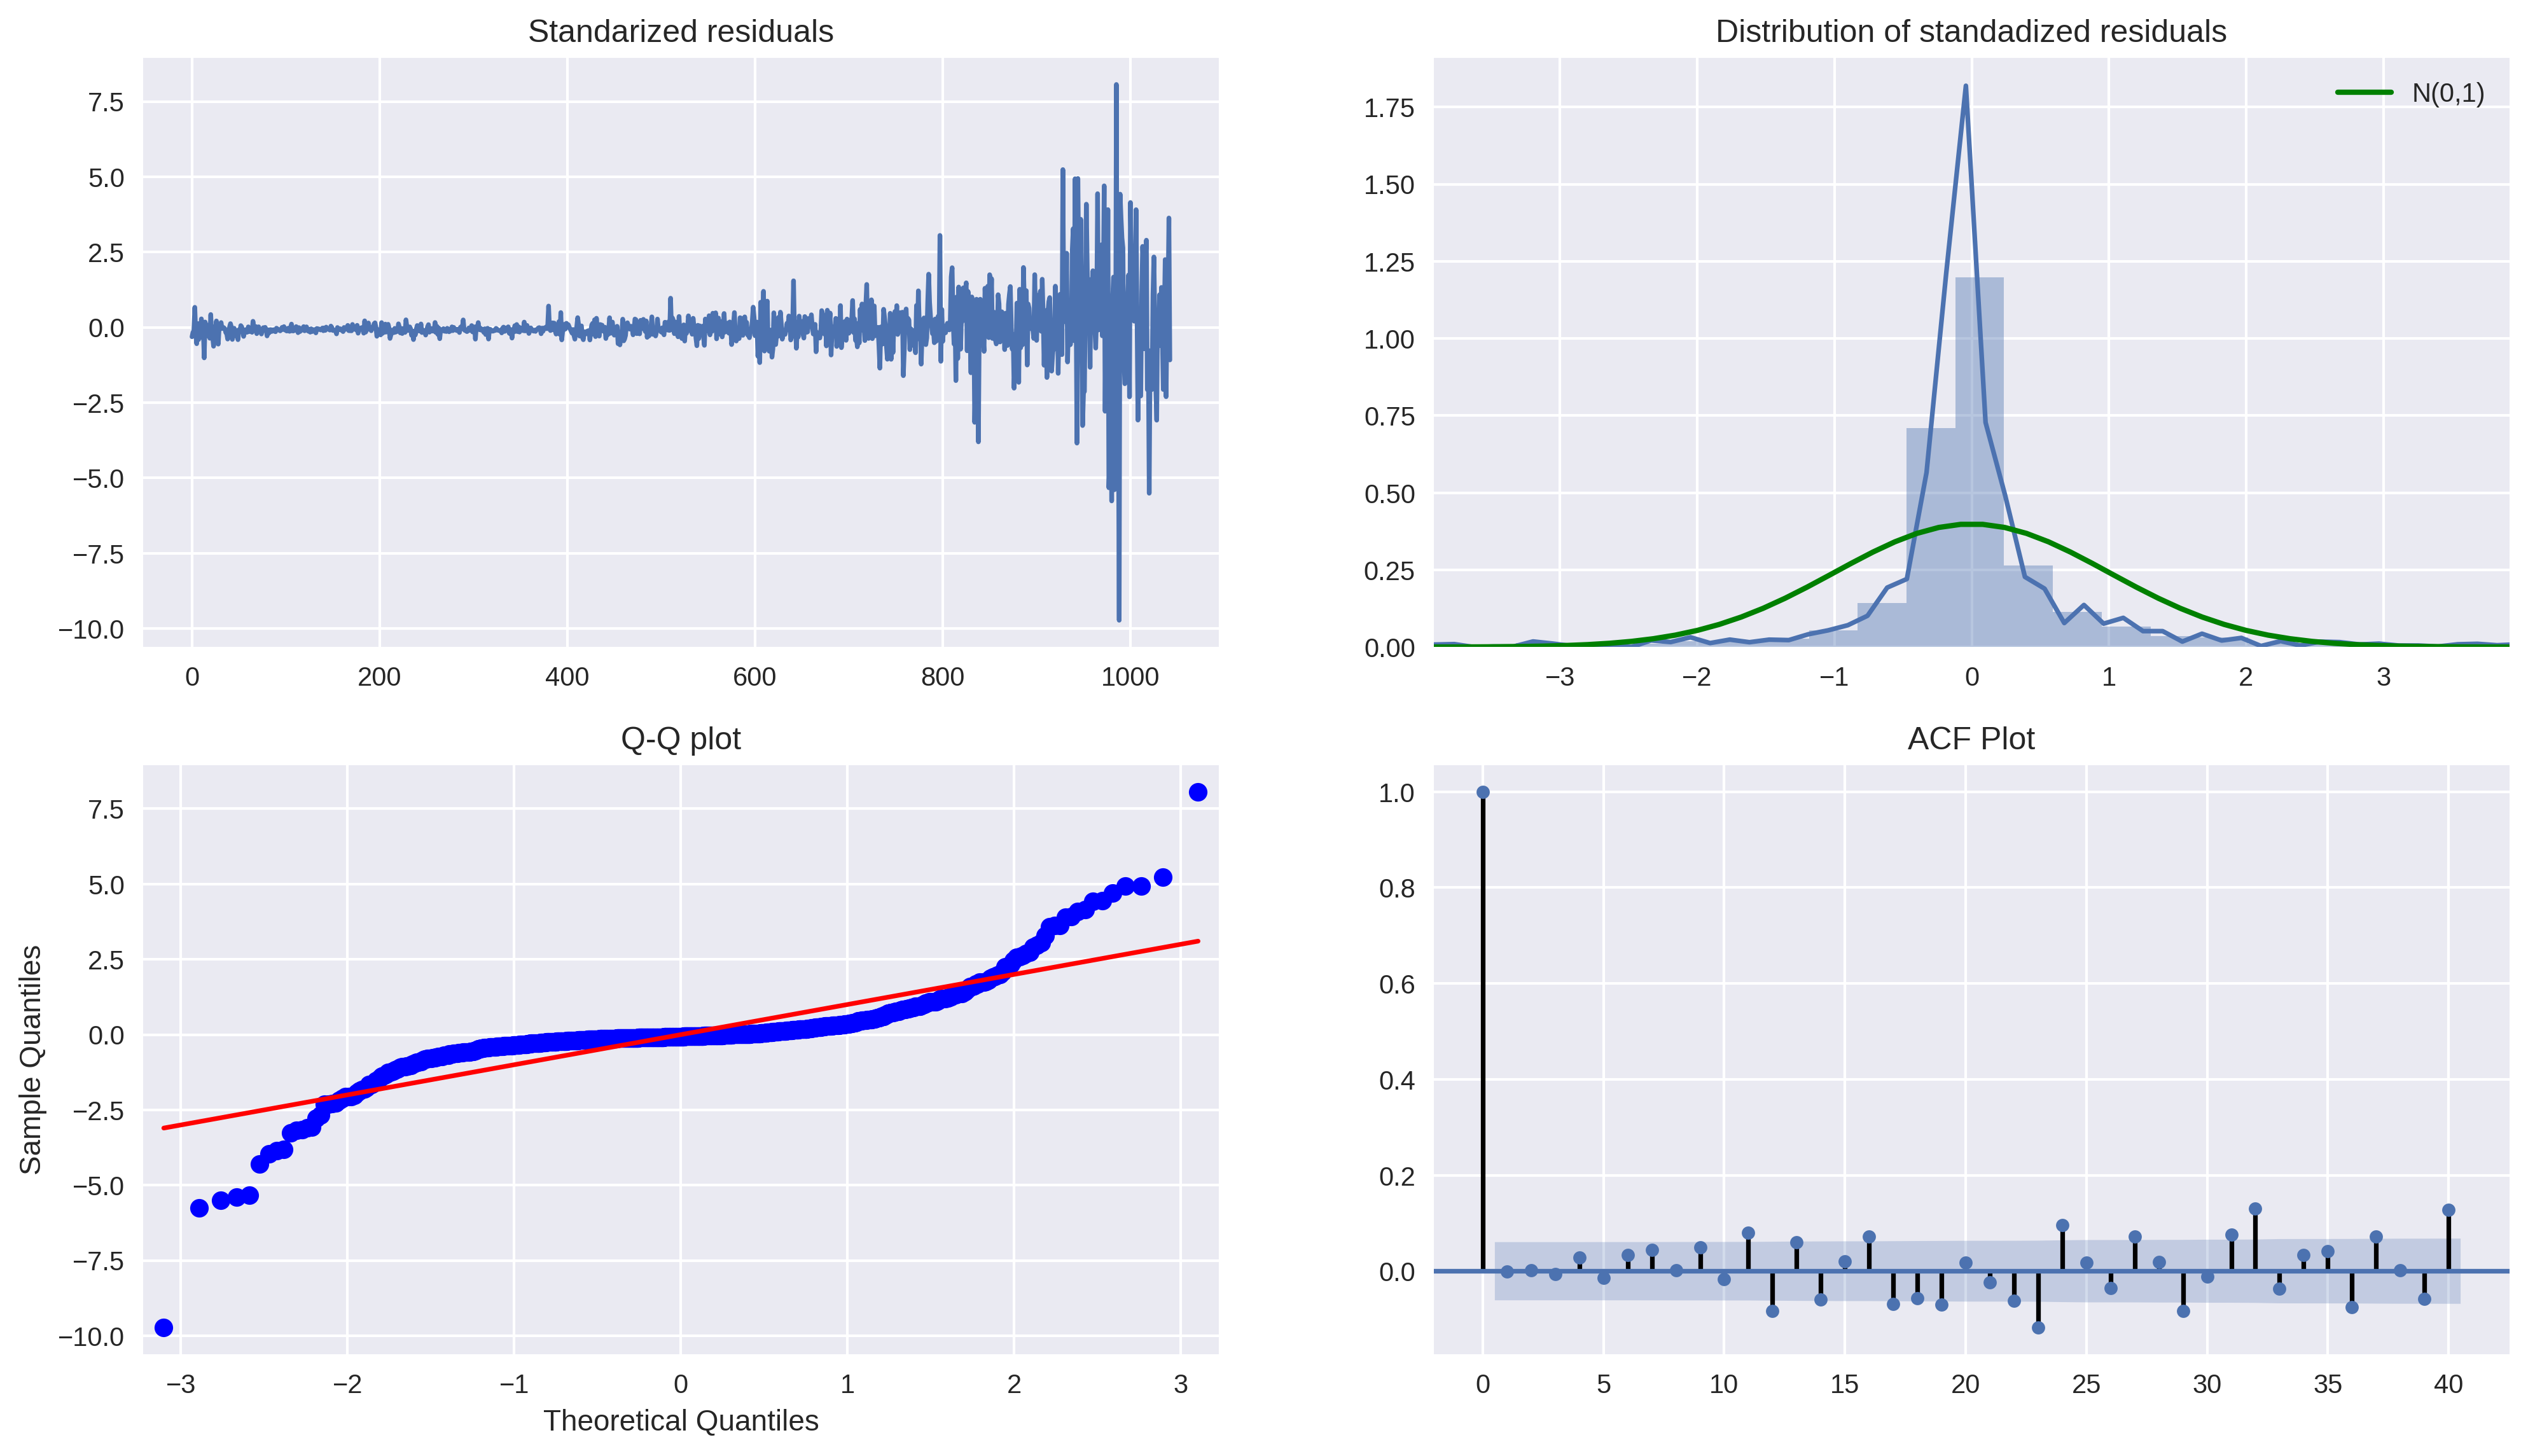

In [65]:
arima_diagnostics(arima.resid, 40)
plt.show()

## Ljung - Box test for no autocorrelation in the residuals

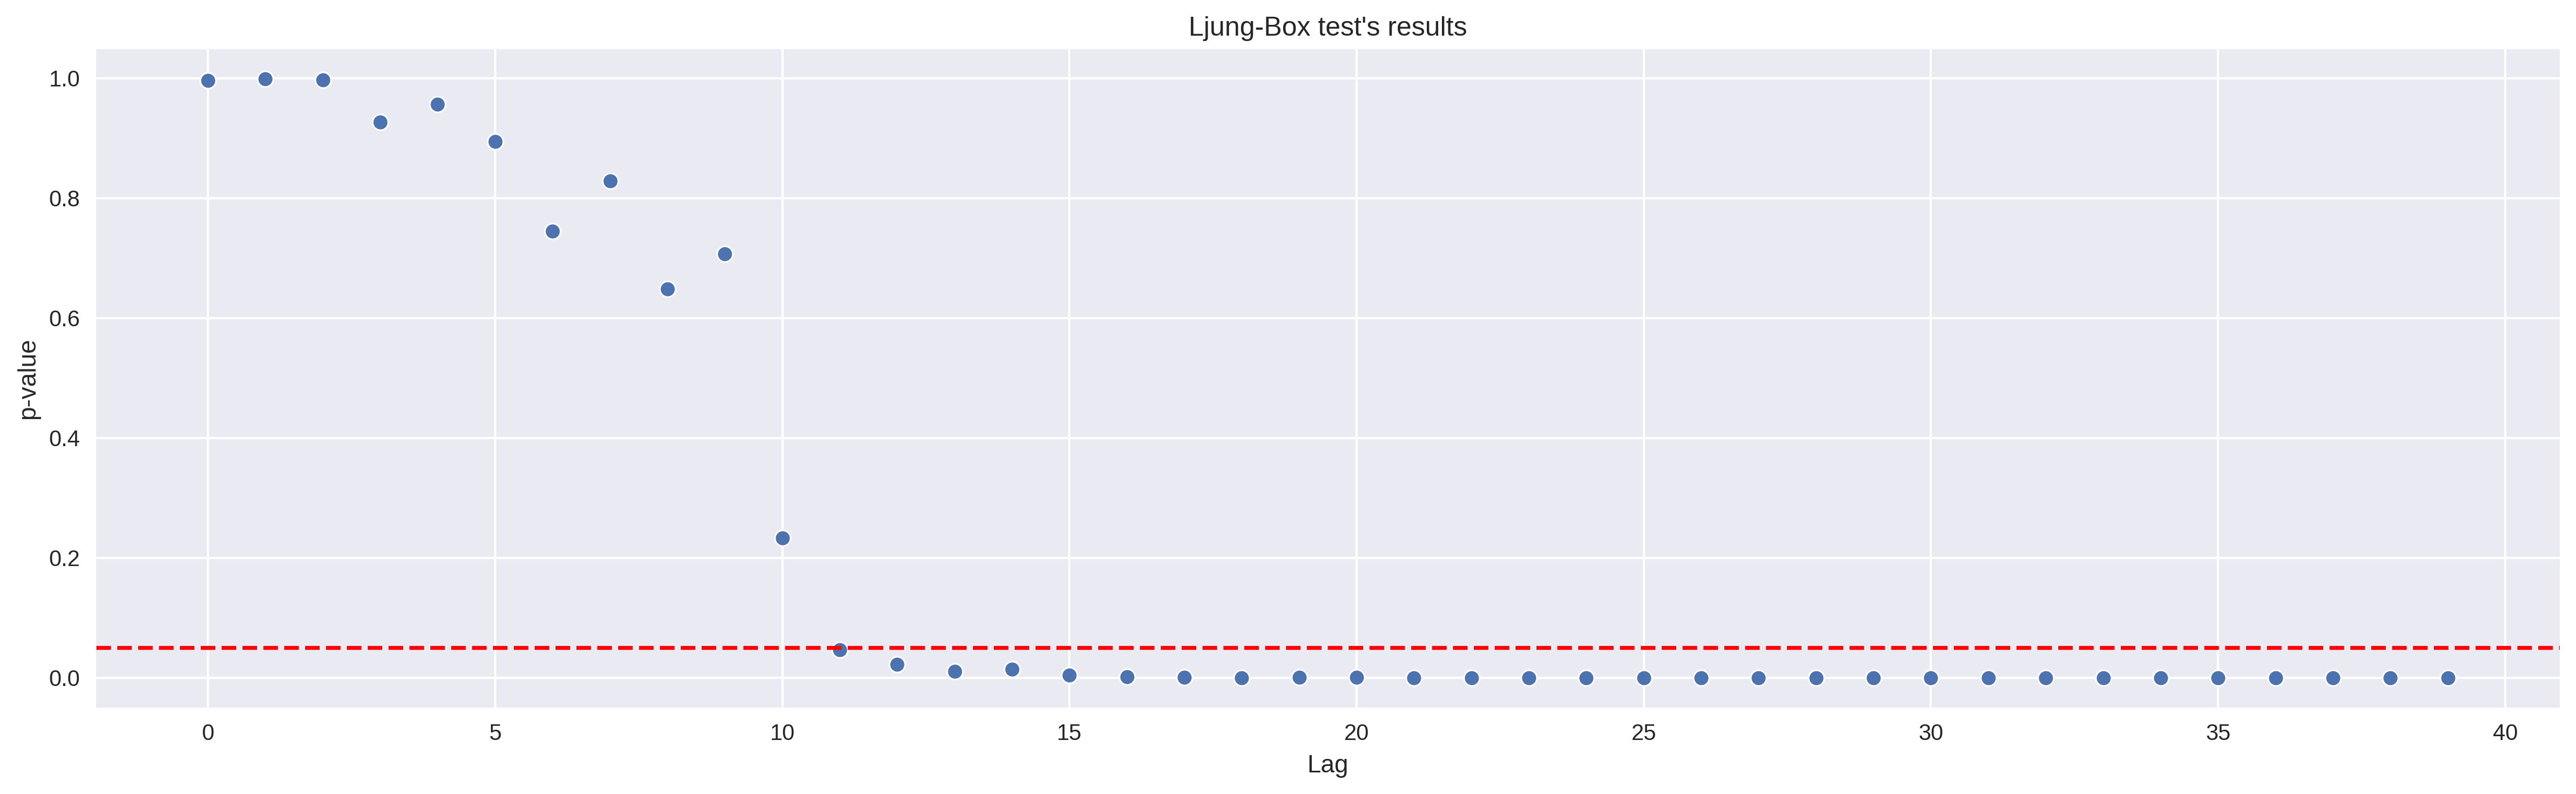

In [66]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()

plt.show()

## Selecting best pdq arguments for the arima model

In [67]:
import pmdarima as pm

In [68]:
model = pm.auto_arima(goog,
                     error_action='ignore',
                     suppress_warnings=True,
                     seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -4709.682
Date:                Sat, 06 Jun 2020   AIC                           9433.363
Time:                        20:34:44   BIC                           9468.006
Sample:                             0   HQIC                          9446.503
                               - 1044                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.007      3.642      0.000       0.011       0.038
ar.L1         -1.7833      0.006   -274.966      0.000      -1.796      -1.771
ar.L2         -0.9518      0.006   -153.886      0.000      -0.964      -0.940
ma.L1          0.7970      0.596      1.337      0.181      -0.371       1.965
ma.L2         -0.8147      1.071     -0.761      0.447      -2.914       1.284
ma.L3         -0.9823      0.586     -1.677      0.094      -2.130       0.166
sigma2       489.9117    292.531      1.675      0.094     -83.438    1063.261
===================================================================================
Ljung-Box (Q):                      163.70   Jarque-Bera (JB):             15108.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             137.25   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
model = pm.auto_arima(goog,
                     error_action='ignore',
                     suppress_warnings=True,
                     seasonal=False,
                     stepwise=False,
                     approximation=False,
                     n_jobs=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -4709.682
Date:                Sat, 06 Jun 2020   AIC                           9433.363
Time:                        20:34:52   BIC                           9468.006
Sample:                             0   HQIC                          9446.503
                               - 1044                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.007      3.642      0.000       0.011       0.038
ar.L1         -1.7833      0.006   -274.966      0.000      -1.796      -1.771
ar.L2         -0.9518      0.006   -153.886      0.000      -0.964      -0.940
ma.L1          0.7970      0.596      1.337      0.181      -0.371       1.965
ma.L2         -0.8147      1.071     -0.761      0.447      -2.914       1.284
ma.L3         -0.9823      0.586     -1.677      0.094      -2.130       0.166
sigma2       489.9117    292.531      1.675      0.094     -83.438    1063.261
===================================================================================
Ljung-Box (Q):                      163.70   Jarque-Bera (JB):             15108.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             137.25   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forcasting using ARIMA class models

In [70]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                 1043
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -4724.057
Method:                       css-mle   S.D. of innovations             22.429
Date:                Sat, 06 Jun 2020   AIC                           9458.114
Time:                        20:35:36   BIC                           9482.864
Sample:                    01-16-2000   HQIC                          9467.502
                         - 01-05-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7007      0.660      2.577      0.010       0.407       2.994
ar.L1.D.adj_close     0.1259      0.390      0.323      0.747      -0.638       0.890
ar.L2.D.adj_close    -0.0601      0.031     -1.927      0.054      -0.121       0.001
ma.L1.D.adj_close    -0.1125      0.390     -0.288      0.773      -0.877       0.652
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0467           -3.9415j            4.0781           -0.2087
AR.2            1.0467           +3.9415j            4.0781            0.2087
MA.1            8.8924           +0.0000j            8.8924            0.0000
-----------------------------------------------------------------------------
"""

In [71]:
auto_arima = pm.auto_arima(goog,
                     error_action='ignore',
                     suppress_warnings=True,
                     seasonal=False,
                     stepwise=False,
                     approximation=False,
                     n_jobs=-1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -4709.682
Date:                Sat, 06 Jun 2020   AIC                           9433.363
Time:                        20:35:45   BIC                           9468.006
Sample:                             0   HQIC                          9446.503
                               - 1044                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.007      3.642      0.000       0.011       0.038
ar.L1         -1.7833      0.006   -274.966      0.000      -1.796      -1.771
ar.L2         -0.9518      0.006   -153.886      0.000      -0.964      -0.940
ma.L1          0.7970      0.596      1.337      0.181      -0.371       1.965
ma.L2         -0.8147      1.071     -0.761      0.447      -2.914       1.284
ma.L3         -0.9823      0.586     -1.677      0.094      -2.130       0.166
sigma2       489.9117    292.531      1.675      0.094     -83.438    1063.261
===================================================================================
Ljung-Box (Q):                      163.70   Jarque-Bera (JB):             15108.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             137.25   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
df = yf.download('GOOG',
                start='2019-01-01',
                end='2019-03-31',
                adjusted=True,
                progress=False)
test = df.resample('W').last().rename(columns={'Adj Close':'adj'})

In [78]:
n_forecasts = len(test)
arima_pred = arima.forecast(n_forecast)
arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
             pd.DataFrame(arima_pred[2], columns=['ci_lower','ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

In [79]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                     return_conf_int=True, 
                                     alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], columns=['ci_lower', 'ci_upper'])]

auto_arima_pred = pd.concat(auto_arima_pred, axis=1).set_index(test.index)

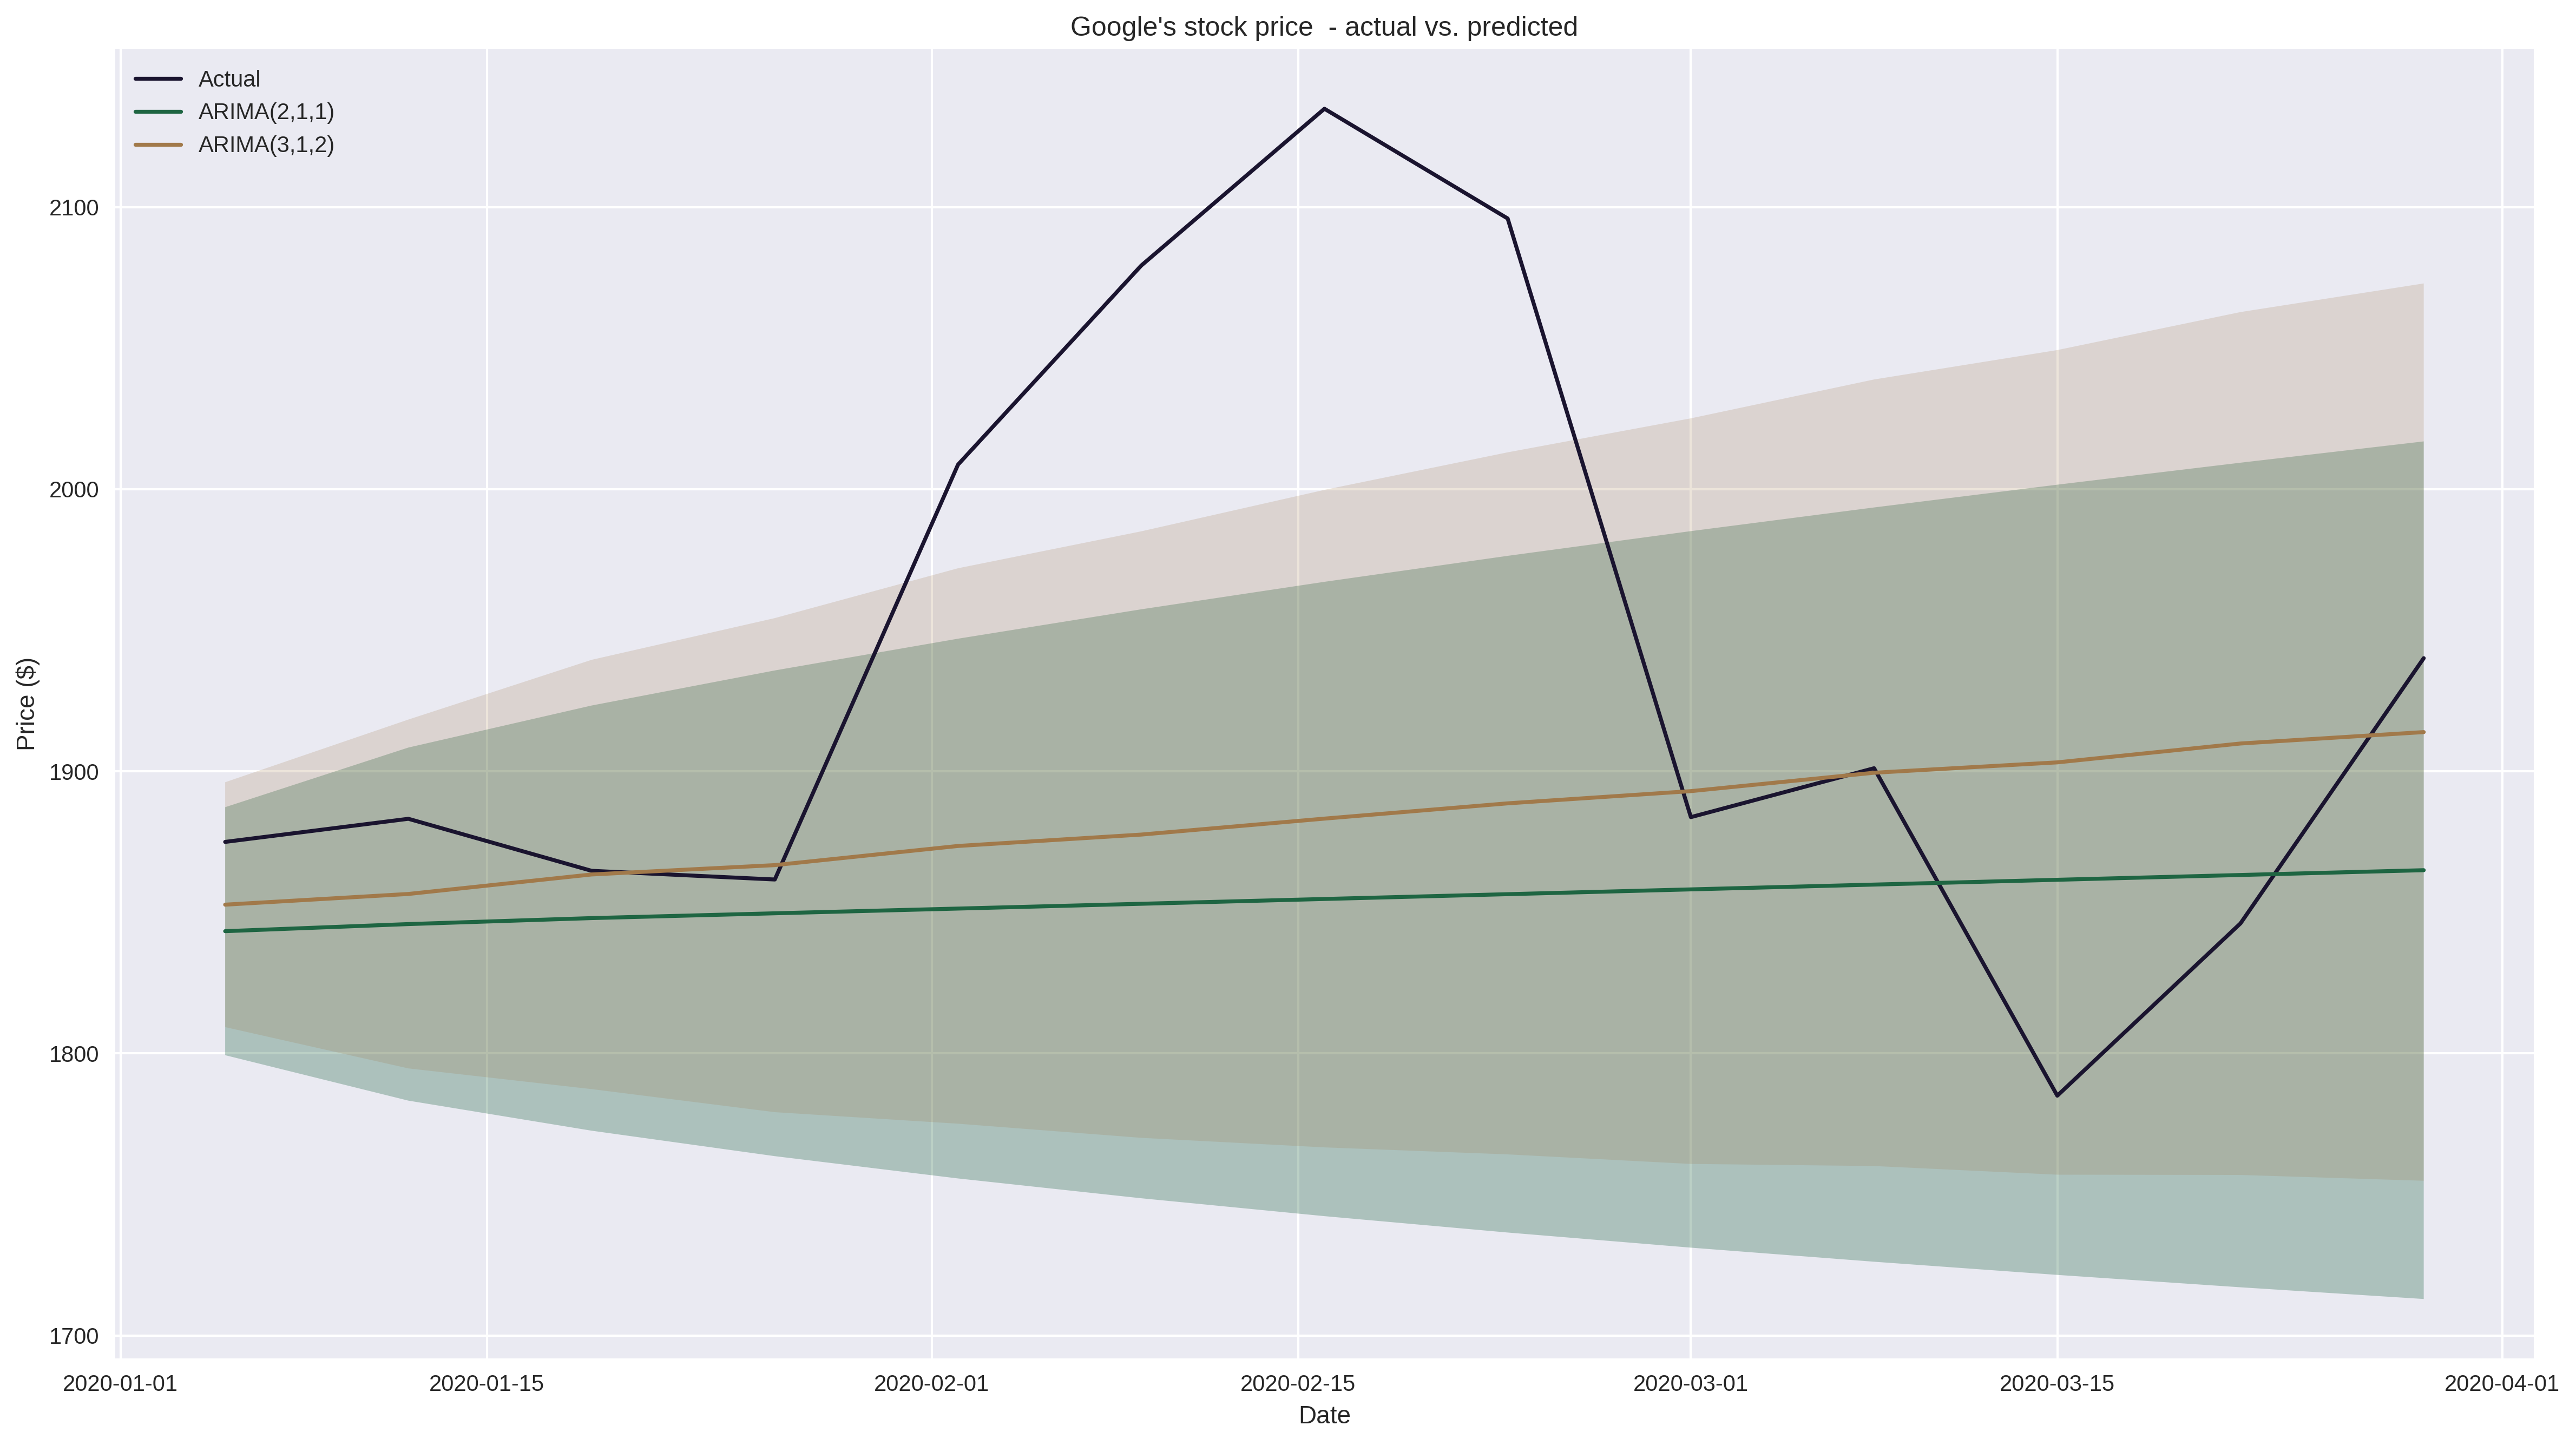

In [80]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,
                arima_pred.ci_lower,
                arima_pred.ci_upper,
                alpha=0.3, 
                facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], 
        label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index,
                auto_arima_pred.ci_lower,
                auto_arima_pred.ci_upper,
                alpha=0.2, 
                facecolor=COLORS[2])

ax.set(title="Google's stock price  - actual vs. predicted", 
       xlabel='Date', 
       ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()

plt.show()

In [55]:

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]